# Daily Arxiv Papers Forecasting with Machine Learning

 My goal is to build regression models to predict the total number of hourly vehicle collison, given other time-dependent features. I have trained the following models:

- Support Vector Machine Regressor

- Random Forest Regressor

- LGBM Regressor

- XGBoost Regressor

In [1]:
%matplotlib inline

# filter warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# set font scale and style
plt.rcParams.update({'font.size': 18})

# pickle
import joblib

# machine learning regression models
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [2]:
# import custom class
%run -i '../src/helper/ml.py'
%run -i '../src/helper/transfxn.py'

In [3]:
# instantiate the  classes
transfxn = TransformationPipeline()
model = RegressionModels()

## Read data

In [4]:
df = pd.read_csv('../data/daily_ts_data.csv')
df['date_created'] = pd.to_datetime(df['date_created'])
df.index = df.date_created
df.drop(['date_created'], axis=1, inplace=True)
print("Data size:", df.shape)
df.head()

Data size: (7224, 7)


,categories,year,month,weekday,season,weekend,count
date_created,,,,,,,
2010-01-01,astro-ph,2010,1,5,winter,False,1
2010-01-01,cond-mat,2010,1,5,winter,False,4
2010-01-01,gr-qc,2010,1,5,winter,False,1
2010-01-01,hep-th,2010,1,5,winter,False,5
2010-01-02,astro-ph,2010,1,6,winter,True,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7224 entries, 2010-01-01 to 2014-12-30
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   categories  7224 non-null   object
 1   year        7224 non-null   int64 
 2   month       7224 non-null   int64 
 3   weekday     7224 non-null   int64 
 4   season      7224 non-null   object
 5   weekend     7224 non-null   bool  
 6   count       7224 non-null   int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 402.1+ KB


## Distribution of the target variable

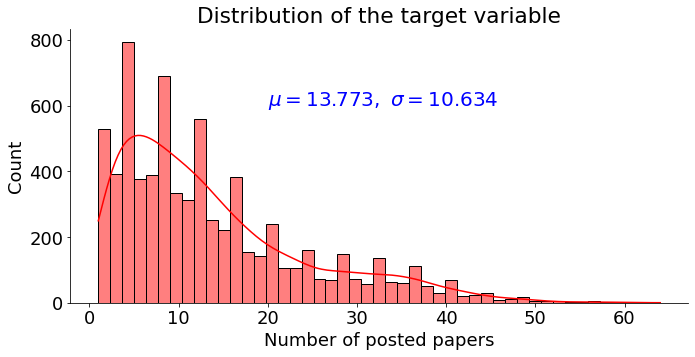

In [6]:
df['y'] = df['count']

# mean and std of the target variable
mu = np.round(df['y'].mean(),3)
sigma = np.round(df['y'].std(),3)

# distribution plot
sns.displot(df['y'], kde=True, height= 5, aspect= 2, color = 'r')
plt.text(20, 600, r'$\mu = {},~ \sigma = {}$'.format(str(mu), str(sigma)),color = 'b', fontsize=20)
plt.xlabel('Number of posted papers')
plt.ylabel('Count')
plt.title("Distribution of the target variable")
plt.show()

## Feature matrix and target variable

In [7]:
# list of columns to drop
drop_cols = ['y','count']

# create feature matrix and target variable
X, y = df.drop(drop_cols, axis =1), df['y']

In [8]:
# convert categorical variables to string
cat_cols = ['month','weekday', 'weekend']
for i in cat_cols:
    X[i] = X[i].astype('O')

## Time series test split

In [9]:
# test size = 20% of the data
ts_cv = TimeSeriesSplit(n_splits=2, gap=0, max_train_size=None, test_size=1423)

In [10]:
all_splits = list(ts_cv.split(X, y))
train_indices, test_indices = all_splits[1]
print('Training set size:', X.iloc[train_indices].shape, y.iloc[train_indices].shape)
print('Test set size:', X.iloc[test_indices].shape, y.iloc[test_indices].shape)

Training set size: (5801, 6) (5801,)
Test set size: (1423, 6) (1423,)


In [11]:
print("Test dataset sample")
print("-" * 20)
X.iloc[test_indices].head()

Test dataset sample
--------------------


,categories,year,month,weekday,season,weekend
date_created,,,,,,
2014-01-01,astro-ph,2014,1,3,winter,False
2014-01-01,cond-mat,2014,1,3,winter,False
2014-01-01,gr-qc,2014,1,3,winter,False
2014-01-01,hep-th,2014,1,3,winter,False
2014-01-02,astro-ph,2014,1,4,winter,False


## Preprocessing & transformations

In [12]:
# transform and scale data
X_train_scaled, X_test_scaled, feat_nm = transfxn.preprocessing(X.iloc[train_indices], 
                                                                X.iloc[test_indices]
                                                               )

In [13]:
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (5801, 30)
Test set size after pre-processing: (1423, 30)


In [14]:
# convert the target to arrays
y_train, y_test = y.iloc[train_indices].values, y.iloc[test_indices].values

## Model Selection by Cross-Validation

## A. Support Vector Regressor

In [15]:
# k-fold timeseries cross-validation
ts_cv = TimeSeriesSplit(n_splits=5, gap=0, max_train_size=None,
                        test_size=int(X_train_scaled.shape[0]*0.2)
                       )

In [16]:
svr = SVR()
model.evaluate_metric_cv(svr, X_train_scaled, y_train, cv_fold=ts_cv, model_nm='SVM regressor')

5-fold cross-validation results for SVM regressor
------------------------------------------------------------
{'wMAPE = 42.425', 'R^2 = 0.144', 'RMSE = 8.067', 'MAE = 6.091'}
------------------------------------------------------------


In [ ]:
# plot wMAPE and MAE for different hyperparamters
model.plot_wmape_svr(X_train_scaled, y_train, cv_fold=ts_cv)

## A-1. Hyperparameter Optimization for SVR

In [17]:
# range of hyperparameters
params = {'C':[2**x for x in range(-2,11,2)], 
          'gamma':[2**x for x in range(-11,1,2)]
          } 
                                                              
# randomized search for SVR
rsearch_svr = RandomizedSearchCV(estimator=SVR(), param_distributions=params, 
                                n_iter = 200, scoring=model.custom_scorer(),
                                cv=ts_cv, n_jobs=-1, random_state=42, verbose=1
                                ) 
# fit the training set
rsearch_svr.fit(X_train_scaled, y_train)

# pickle trained model 
joblib.dump(rsearch_svr.best_estimator_, '../data/svr.pkl')
print('Best wMAPE score:', -rsearch_svr.best_score_)
print('Best parameters:', rsearch_svr.best_params_)  

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best wMAPE score: 29.70958756299523
Best parameters: {'gamma': 0.0078125, 'C': 16}


## B. Random Forest Regressor

In [19]:
rf = RandomForestRegressor(random_state = 42) 
model.evaluate_metric_cv(rf, X_train_scaled, y_train, cv_fold=ts_cv, model_nm='Random forest regressor')

5-fold cross-validation results for Random forest regressor
------------------------------------------------------------
{'R^2 = 0.192', 'RMSE = 7.544', 'MAE = 5.772', 'wMAPE = 40.237'}
------------------------------------------------------------


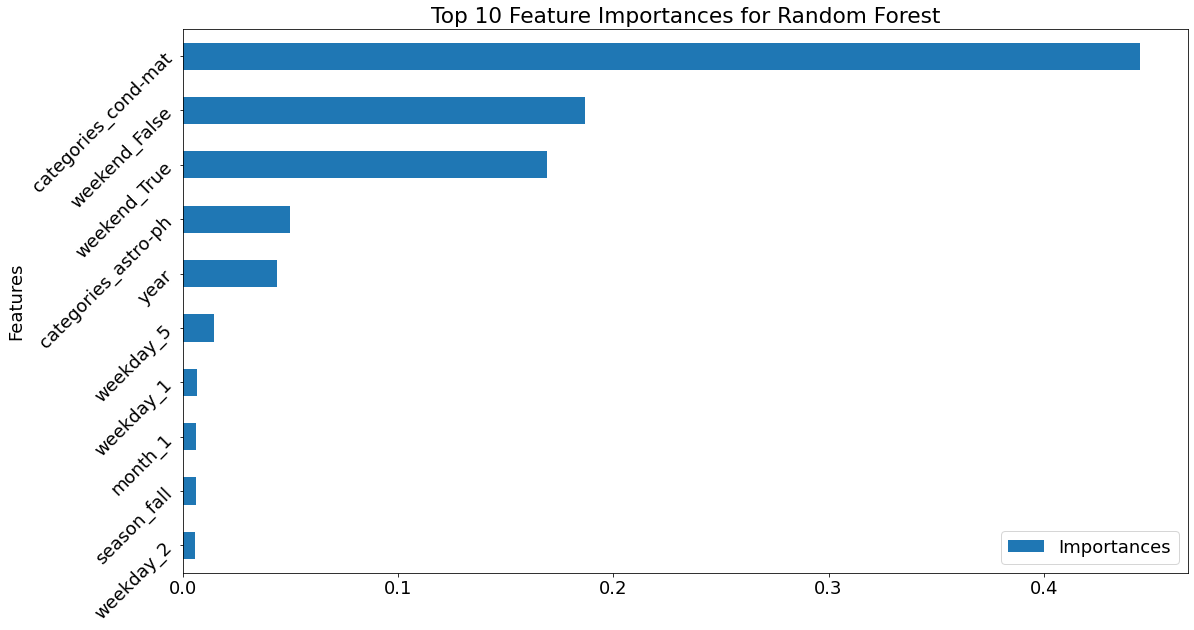

In [20]:
# fit model
rf.fit(X_train_scaled, y_train)

# compute feature importances
importances_df = pd.DataFrame({'Features':feat_nm, 'Importances':rf.feature_importances_ })

# plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(10).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 10 Feature Importances for Random Forest')
plt.savefig('../images/rf.png')

## B-1. Hyperparameter Optimization for Random Forest

In [20]:
# hyperparameter range
params = {'max_features': ['auto', 'sqrt', 'log2'],
          'max_depth': [10, 20, 30, None],
          'min_samples_split': range(2,10,1),
          'bootstrap': [True, False]
         }

# randomized search
rf =  RandomForestRegressor(n_estimators=100, random_state=42)                       
rsearch_rf = RandomizedSearchCV(estimator=rf, param_distributions=params, 
                                n_iter=200, scoring=model.custom_scorer(),
                                cv=ts_cv, n_jobs=-1, random_state=42, verbose=1
                               )  

# fit model
rsearch_rf.fit(X_train_scaled, y_train)

# pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../data/rf.pkl')
print('Best wMAPE score:', -rsearch_rf.best_score_) 
print('Best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best wMAPE score: 27.763282510731443
Best hyperparameters: {'min_samples_split': 7, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


## C. LGBM Regressor

In [21]:
param_dict = {'boosting_type':'gbdt', 'num_leaves':31, 
              'max_depth':- 1, 'learning_rate':0.1, 
              'n_estimators':100, 'random_state':42
             }
              
lgbm = lgb.LGBMRegressor(**param_dict)
model.evaluate_metric_cv(lgbm, X_train_scaled, y_train, cv_fold=ts_cv, model_nm='LGBM regressor')

5-fold cross-validation results for LGBM regressor
------------------------------------------------------------
{'R^2 = nan', 'RMSE = nan', 'MAE = nan', 'wMAPE = nan'}
------------------------------------------------------------


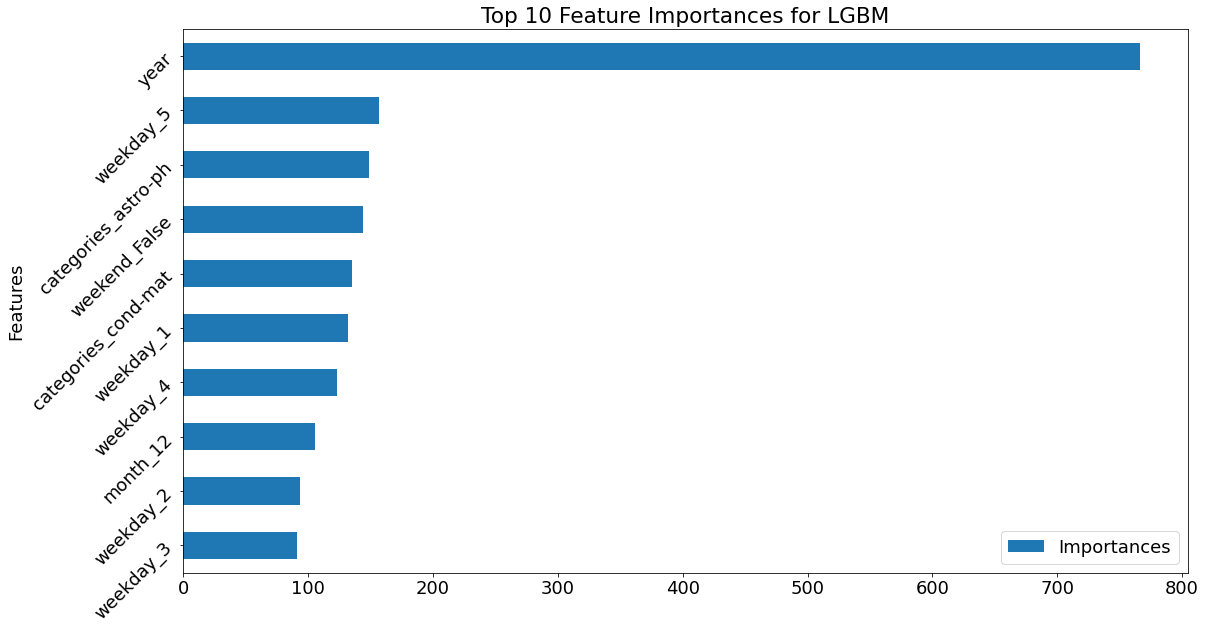

In [22]:
# fit model
lgbm.fit(X_train_scaled, y_train)

# compute feature importances
importances_df = pd.DataFrame({'Features': feat_nm, 'Importances': lgbm.feature_importances_})
# plot
importances_df.sort_values('Importances', ascending = True, inplace = True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(10).plot(kind='barh', figsize = (18,10))
plt.yticks(rotation = 45)
plt.title('Top 10 Feature Importances for LGBM')
plt.savefig('../images/lgbm.png')

## C-1. Hyperparameter Optimization for LGBM

In [23]:
# hyperparameter range
params = {'max_depth': [10, 20, 30],
          'num_leaves': range(90,120,5),
          'min_child_samples': range(20,50,10),
          'learning_rate': [0.01, 0.02, 0.05]
          }

# randomized search
lgbm =  lgb.LGBMRegressor(n_estimators=1000, random_state=42)                       
rsearch_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=params, 
                                n_iter=200, scoring=model.custom_scorer(),
                                cv=ts_cv, n_jobs=-1, random_state=42, verbose=1
                                 )  
# fit model
rsearch_lgbm.fit(X_train_scaled, y_train)

# pickle trained model
joblib.dump(rsearch_lgbm.best_estimator_, '../data/lgbm.pkl')
print('Best wMAPE score:', -rsearch_lgbm.best_score_) 
print('Best hyperparameters:', rsearch_lgbm.best_params_) 

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best wMAPE score: 27.915918867609655
Best hyperparameters: {'num_leaves': 90, 'min_child_samples': 30, 'max_depth': 10, 'learning_rate': 0.01}


## D. XGBoost

In [18]:
param_dict = { 'objective':'reg:squarederror', 'n_estimators':100, 
              'learning_rate':0.05, 'random_state':42,'n_jobs':-1  
             }
              
xgb_ = xgb.XGBRegressor(**param_dict)
model.evaluate_metric_cv(xgb_, X_train_scaled, y_train, cv_fold=ts_cv, model_nm='XGBoost regressor')

5-fold cross-validation results for XGBoost regressor
------------------------------------------------------------
{'wMAPE = 39.548', 'R^2 = 0.202', 'MAE = 5.674', 'RMSE = 7.406'}
------------------------------------------------------------


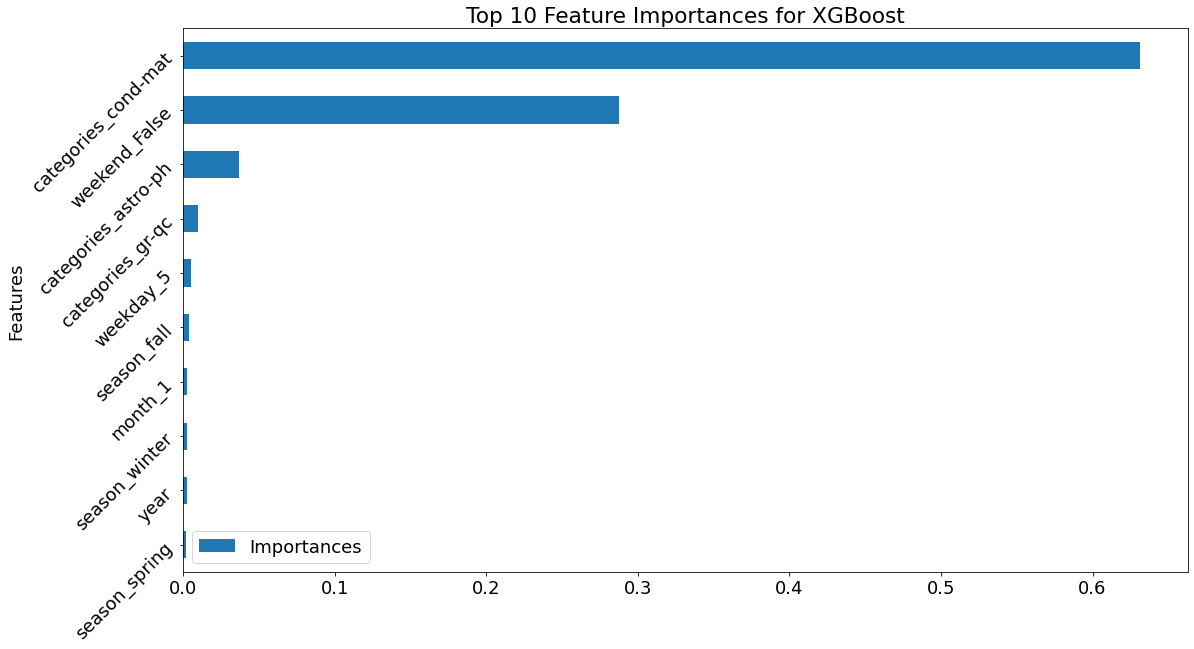

In [23]:
# fit model
xgb_.fit(X_train_scaled, y_train)

# compute feature importances
importances_df = pd.DataFrame({'Features': feat_nm, 'Importances': xgb_.feature_importances_})

# plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace=True)
importances_df.tail(10).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 10 Feature Importances for XGBoost')
plt.savefig('../images/xgb.png')

## D-1. Hyperparameter Optimization for XGBoost

In [26]:
# range of hyperparameters
params = {'max_depth': range(1,10,2), 
          'min_child_weight': range(1,6,2),
          'gamma':[i/100 for i in range(0,6)],
          'subsample':[i/10 for i in range(5,9)],
          'colsample_bytree': [i/10 for i in range(5,9)]
          }

# randomized search
param_dist = { 'objective':'reg:squarederror', 'learning_rate':0.1,
              'n_estimators':100,'random_state':42,'n_jobs':-1  
             }    
xgb_ = xgb.XGBRegressor(**param_dist)
rsearch_xgb = RandomizedSearchCV(estimator=xgb_, param_distributions=params, 
                                 scoring=model.custom_scorer(), 
                                 cv=ts_cv, n_jobs=-1, n_iter=200, 
                                 random_state=42, verbose=1
                                )   
# fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../data/xgb_.pkl')
print('Best wMAPE score:', -rsearch_xgb.best_score_) 
print('Best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best wMAPE score: 26.32893636666396
Best hyperparameters: {'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 7, 'gamma': 0.0, 'colsample_bytree': 0.8}


In [61]:
# load trained model
svr = joblib.load('../data/svr.pkl')
rf = joblib.load('../data/rf.pkl')
lgbm = joblib.load('../data/lgbm.pkl')
xgb_ = joblib.load('../data/xgb_.pkl')

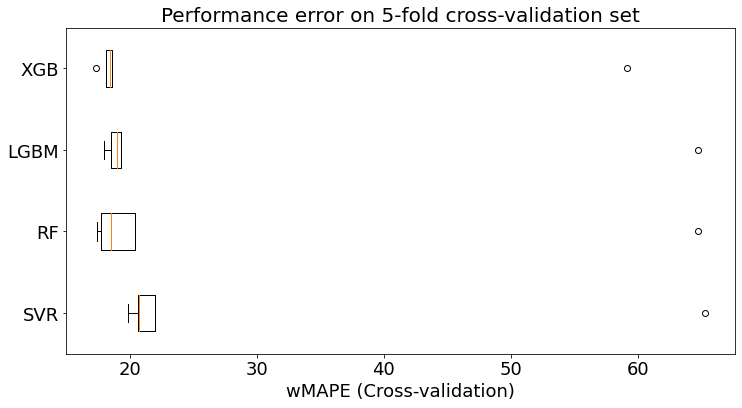

In [63]:
model_dict = {'SVR':svr, 'RF':rf, 'LGBM':lgbm, 'XGB':xgb_}
scores = []
for i, (name, ml_model) in enumerate(model_dict.items()):
    score = cross_val_score(ml_model, X_train_scaled, y_train, cv=ts_cv, 
                            scoring=model.custom_scorer()
                           )
    scores.append(-score)

plt.figure(figsize = (12,6))
plt.boxplot(scores, vert = False)
plt.yticks(np.arange(len(model_dict))+1, list(model_dict.keys()))
plt.xlabel('wMAPE (Cross-validation)')
plt.title('Performance error on 5-fold cross-validation set', fontsize = 20)
plt.savefig('../images/cv_error.png')
plt.show()

## Test Set Predictions

## A. Support Vector regressor

In [64]:
model.evaluate_metric_test(svr.predict(X_test_scaled), y_test, model_nm='Support Vector regressor')

Test prediction results for Support Vector regressor
------------------------------------------------------------
{'R^2 = 0.819', 'MAE = 0.051', 'RMSE = 0.061', 'WMAPE = 26.16'}
------------------------------------------------------------


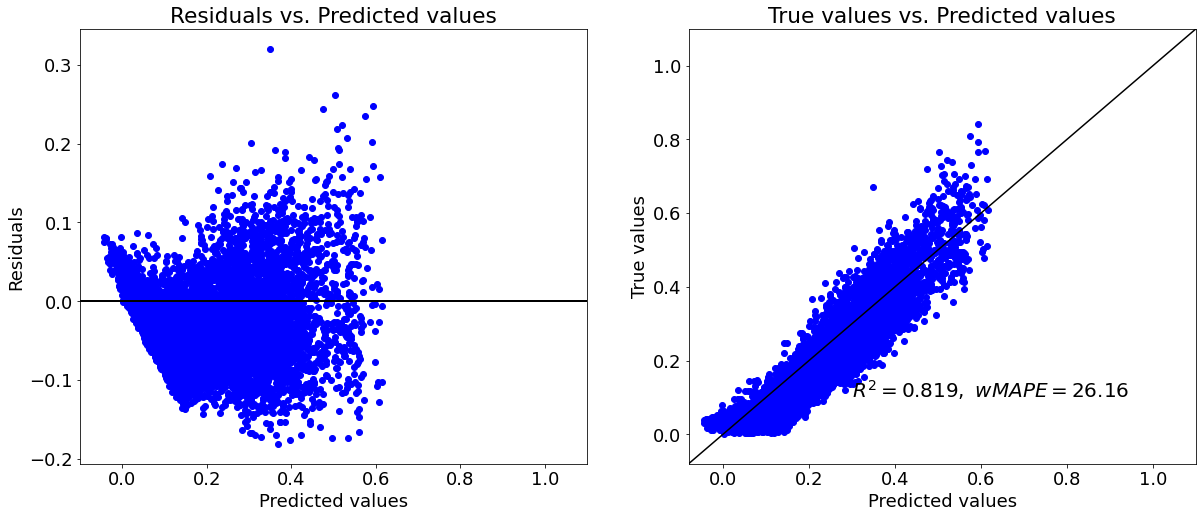

In [65]:
model.diagnostic_plot_(svr.predict(X_test_scaled), y_test, ylim=None)

## B. Random Forest Regressor

In [24]:
model.evaluate_metric_test(rf.predict(X_test_scaled), y_test, model_nm='Random forest regressor')

Test prediction results for Random forest regressor
------------------------------------------------------------
{'MAE = 5.386', 'R^2 = 0.387', 'RMSE = 7.483', 'WMAPE = 47.154'}
------------------------------------------------------------


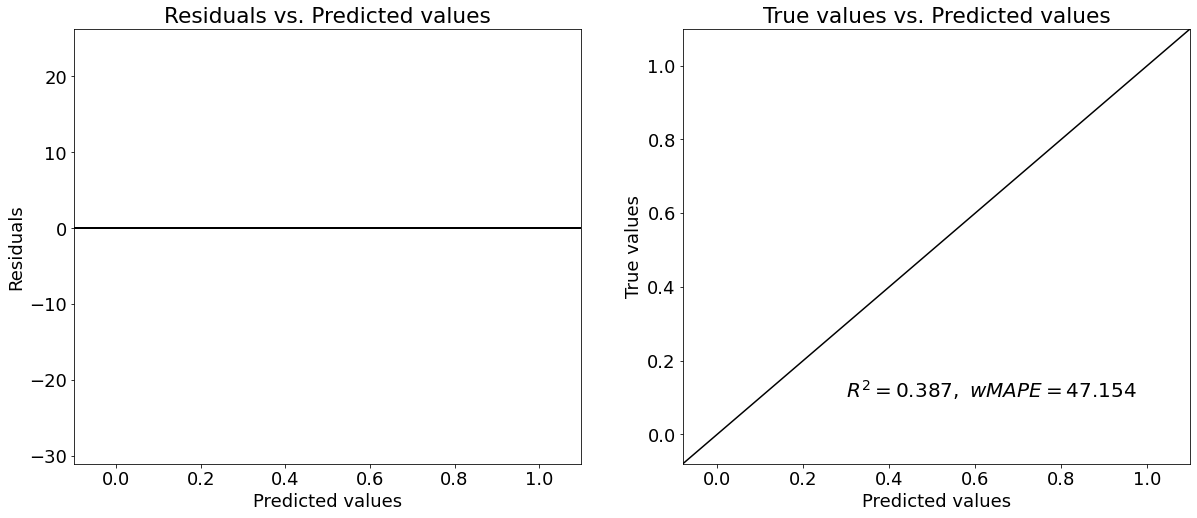

In [25]:
model.diagnostic_plot_(rf.predict(X_test_scaled), y_test, ylim=None)

## C. LGBM Regressor

In [68]:
model.evaluate_metric_test(lgbm.predict(X_test_scaled), y_test, model_nm='LGBM regressor')

Test prediction results for LGBM regressor
------------------------------------------------------------
{'MAE = 0.037', 'R^2 = 0.882', 'WMAPE = 19.155', 'RMSE = 0.05'}
------------------------------------------------------------


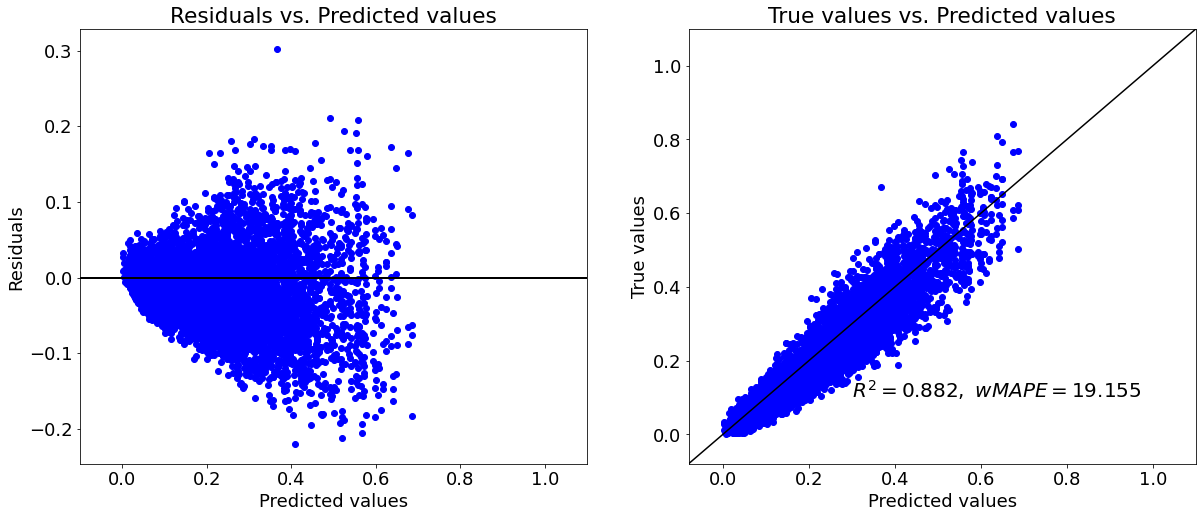

In [69]:
model.diagnostic_plot_(lgbm.predict(X_test_scaled), y_test, ylim=None)

## D. XGBoost Regressor

In [70]:
model.evaluate_metric_test(xgb_.predict(X_test_scaled), y_test, model_nm='XGBoost regressor')

Test prediction results for XGBoost regressor
------------------------------------------------------------
{'MAE = 0.036', 'RMSE = 0.049', 'R^2 = 0.886', 'WMAPE = 18.763'}
------------------------------------------------------------


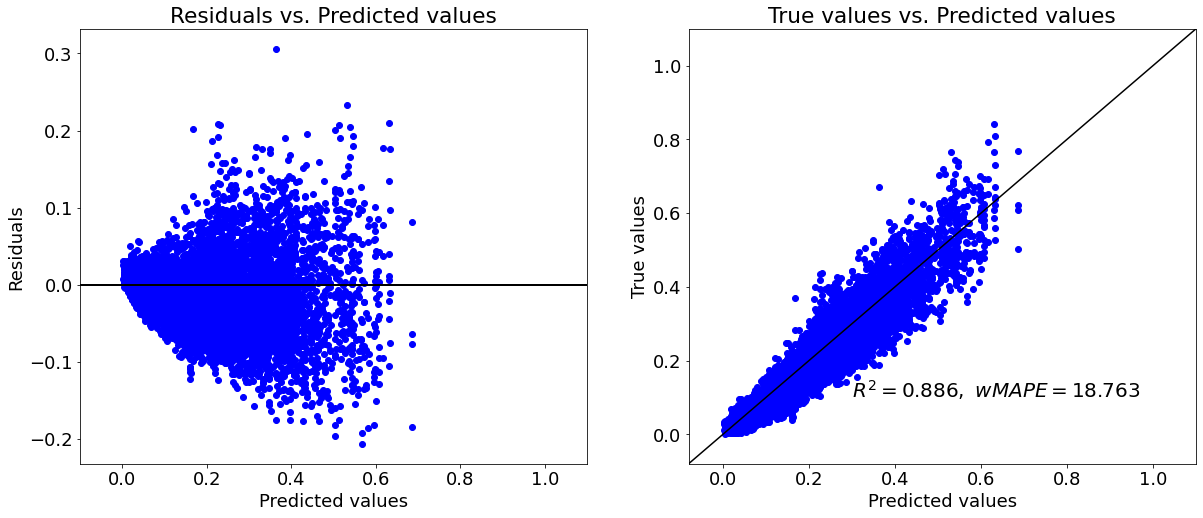

In [71]:
model.diagnostic_plot_(xgb_.predict(X_test_scaled), y_test, ylim=None)

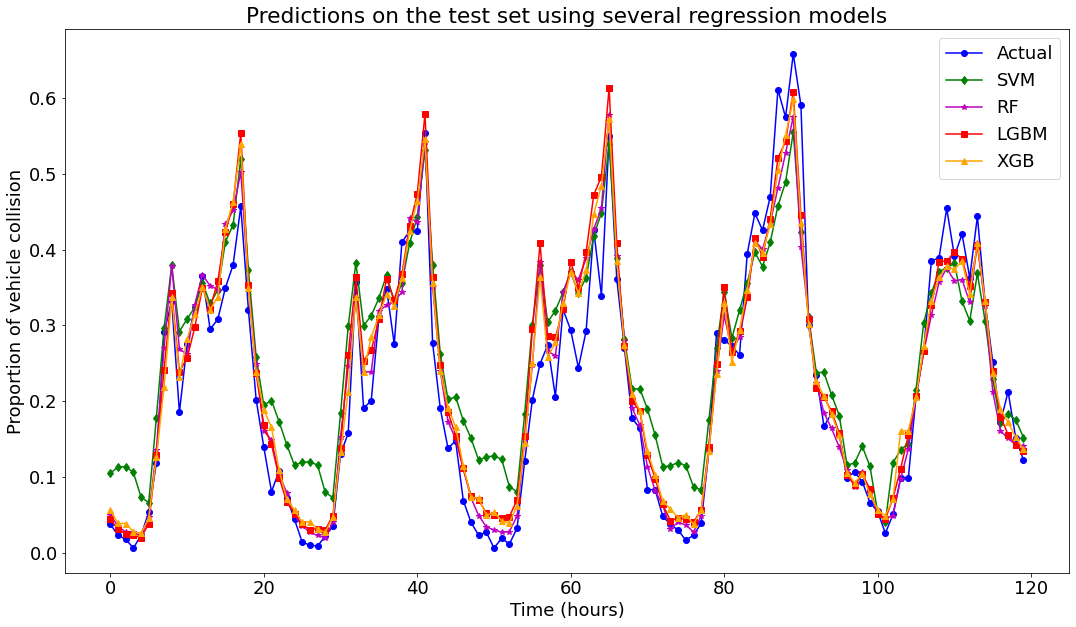

In [72]:
plt.subplots(figsize=(18, 10))
plt.plot(y_test[-120:], color = "b", marker = 'o',  label="Actual")
plt.plot(svr.predict(X_test_scaled)[-120:], color="g", marker='d', label="SVM")
plt.plot(rf.predict(X_test_scaled)[-120:], color='m', marker = '*', label="RF")
plt.plot(lgbm.predict(X_test_scaled)[-120:], color="r", marker = 's', label="LGBM")
plt.plot(xgb_.predict(X_test_scaled)[-120:], color='orange', marker = '^', label="XGB")
plt.title("Predictions on the test set using several regression models")
plt.xlabel("Time (hours)")
plt.ylabel("Proportion of vehicle collision")
plt.legend(loc='best')
plt.savefig('../images/result.png')
plt.show()

## Model Diagnostics

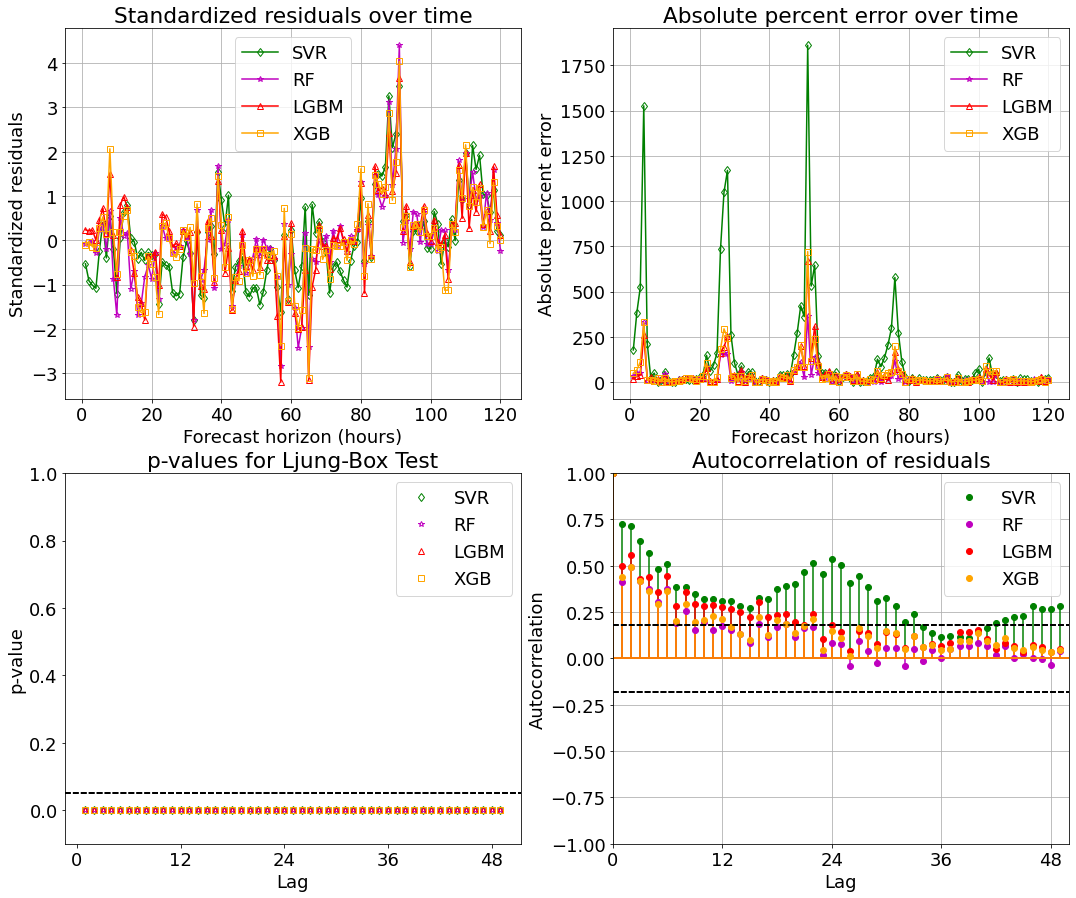

In [73]:
plt.figure(figsize=(18, 15))
model.diagnostic_plot(y_test[-120:], svr.predict(X_test_scaled)[-120:], 
                      marker='d', color='g', label='SVR'
                     )
model.diagnostic_plot(y_test[-120:], rf.predict(X_test_scaled)[-120:], 
                      marker='*', color='m', label='RF'
                     )
model.diagnostic_plot(y_test[-120:], lgbm.predict(X_test_scaled)[-120:], 
                      marker='^', color='r', label='LGBM'
                     )
model.diagnostic_plot(y_test[-120:], xgb_.predict(X_test_scaled)[-120:], 
                      marker='s', color='orange', label='XGB'
                     )